In [1]:
import torch
from torch import nn
import tqdm
from einops import rearrange
import numpy as np
import pytorch_lightning
import matplotlib.pyplot as plt
from pytorch_lightning.utilities import move_data_to_device

from case_studies.dc2_mdt.utils.gaussian_diffusion import (GaussianDiffusion,
                                                           get_named_beta_schedule,
                                                           ModelMeanType,
                                                           ModelVarType,
                                                           LossType)
from case_studies.dc2_mdt.utils.respace import space_timesteps, SpacedDiffusion
from case_studies.dc2_mdt.utils.resample import create_named_schedule_sampler, ScheduleSampler, SpeedSampler
from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator

In [2]:
image_size = 4
max_objects = 2
image_normalize_strategy = "linear_scale"

In [3]:
# class SimpleMLP(nn.Module):
#     def __init__(self, layers, hidden_ch):
#         super().__init__()

#         self.network = nn.Sequential(
#             nn.Linear(1 + 1 + 16, hidden_ch),
#             nn.ReLU(),
#             *[
#                 nn.Sequential(
#                     nn.Linear(hidden_ch, hidden_ch),
#                     nn.LayerNorm(hidden_ch),
#                     nn.ReLU(),
#                 ) for _ in range(layers)
#             ],
#             nn.Linear(hidden_ch, 1)
#         )
    
#     def forward(self, x, t, image):
#         x = torch.cat([x, t.unsqueeze(1), image.flatten(start_dim=1)], dim=1)
#         return self.network(x)

In [4]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])
        self.input_embed = nn.Sequential(
            nn.Linear(int(np.prod(data_shape)), hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size * max_objects, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch * 2, hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

    def forward(self, x, t, image):
        t = t.unsqueeze(-1)
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange([sin_embed_t, cos_embed_t], "d b w -> b (d w)")
        )
        embed_xt = self.input_embed(x.flatten(1))
        embed_image = self.image_embed(image.flatten(1))
        out = self.layers(
            torch.cat([embed_xt + embed_t, embed_image], dim=-1)
        )
        return out.view(x.shape)

In [70]:
device = torch.device("cuda:6")
batch_size = 1024
val_batch_size = 10_000
training_time_steps = 1000
training_iters = 30_000
val_iters = 2500
ddim_steps = 100
ddim_eta = 0.0
log_freq = 500
seed = 7272
pytorch_lightning.seed_everything(seed)

Seed set to 7272


7272

In [71]:
diffusion_config = {
    "betas": get_named_beta_schedule("linear", training_time_steps),
    "model_mean_type": ModelMeanType.EPSILON,
    "model_var_type": ModelVarType.FIXED_LARGE,
    "loss_type": LossType.MSE
}
training_diffusion = GaussianDiffusion(**diffusion_config)
sampling_diffusion = SpacedDiffusion(use_timesteps=space_timesteps(training_time_steps, f"ddim{ddim_steps}"),
                                      **diffusion_config)
schedule_sampler = create_named_schedule_sampler("uniform", training_diffusion)
# schedule_sampler = SpeedSampler(diffusion=training_diffusion,
#                                 lam=0.6,
#                                 k=5,
#                                 tau=700)
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0 if image_size > 1 else 0.1,
                                 flux_alpha=10.0,
                                 flux_beta=0.01).to(device=device)

In [7]:
my_net = FourierMLP(data_shape=[1,], 
                    num_layers=8, 
                    hidden_ch=256).to(device=device)
# my_net = SimpleMLP(layers=8, hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [8]:
# max_flux_boundary = 3000.0
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     flux = flux.clamp(max=max_flux_boundary)
#     return (torch.log1p(flux) / torch.log1p(torch.tensor(max_flux_boundary))) * 2 - 1

# def decode_flux(flux_minus1_to_1: torch.Tensor):
#     assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
#     return torch.expm1((flux_minus1_to_1 + 1) / 2 * torch.log1p(torch.tensor(max_flux_boundary)))

In [9]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (flux / max_flux_boundary) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [10]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    t, batch_sample_weights, batch_loss_weights = schedule_sampler.sample(batch_size, device=device)
    target_fluxes = catalog["fluxes"][:, 0:1]  # (b, 1)
    input_image = catalog["images"].permute([0, 3, 1, 2])  # (b, m, h, w)
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image = input_image / 1000
        case _:
            raise NotImplementedError()
    train_loss_args = {
        "model": my_net,
        "x_start": encode_flux(target_fluxes),
        "t": t,
        "loss_weights": batch_loss_weights
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

  2%|▏         | 509/30000 [00:09<08:32, 57.49it/s]

[500/30000] loss: 2.960e-02


  3%|▎         | 1007/30000 [00:17<08:28, 56.96it/s]

[1000/30000] loss: 2.836e-02


  5%|▌         | 1509/30000 [00:26<08:13, 57.77it/s]

[1500/30000] loss: 3.955e-02


  7%|▋         | 2008/30000 [00:35<08:04, 57.77it/s]

[2000/30000] loss: 3.816e-02


  8%|▊         | 2510/30000 [00:43<07:59, 57.28it/s]

[2500/30000] loss: 3.078e-02


 10%|█         | 3010/30000 [00:52<07:29, 60.04it/s]

[3000/30000] loss: 3.316e-02


 12%|█▏        | 3511/30000 [01:01<07:38, 57.73it/s]

[3500/30000] loss: 2.908e-02


 13%|█▎        | 4008/30000 [01:09<07:20, 59.00it/s]

[4000/30000] loss: 3.215e-02


 15%|█▌        | 4506/30000 [01:17<07:14, 58.74it/s]

[4500/30000] loss: 3.454e-02


 17%|█▋        | 5008/30000 [01:26<07:07, 58.45it/s]

[5000/30000] loss: 3.295e-02


 18%|█▊        | 5509/30000 [01:35<06:54, 59.09it/s]

[5500/30000] loss: 3.566e-02


 20%|██        | 6010/30000 [01:43<06:59, 57.14it/s]

[6000/30000] loss: 2.777e-02


 22%|██▏       | 6510/30000 [01:52<06:38, 58.89it/s]

[6500/30000] loss: 2.348e-02


 23%|██▎       | 7005/30000 [02:02<08:04, 47.44it/s]

[7000/30000] loss: 2.756e-02


 25%|██▌       | 7507/30000 [02:13<07:59, 46.90it/s]

[7500/30000] loss: 2.280e-02


 27%|██▋       | 8005/30000 [02:23<07:50, 46.74it/s]

[8000/30000] loss: 2.783e-02


 28%|██▊       | 8510/30000 [02:32<06:12, 57.66it/s]

[8500/30000] loss: 2.711e-02


 30%|███       | 9011/30000 [02:41<06:02, 57.93it/s]

[9000/30000] loss: 2.409e-02


 32%|███▏      | 9510/30000 [02:49<05:54, 57.73it/s]

[9500/30000] loss: 2.450e-02


 33%|███▎      | 10011/30000 [02:58<05:32, 60.18it/s]

[10000/30000] loss: 2.297e-02


 35%|███▌      | 10509/30000 [03:07<05:39, 57.41it/s]

[10500/30000] loss: 2.607e-02


 37%|███▋      | 11007/30000 [03:15<05:13, 60.66it/s]

[11000/30000] loss: 2.843e-02


 38%|███▊      | 11507/30000 [03:24<05:18, 58.03it/s]

[11500/30000] loss: 2.716e-02


 40%|████      | 12007/30000 [03:32<05:09, 58.13it/s]

[12000/30000] loss: 1.943e-02


 42%|████▏     | 12507/30000 [03:41<04:57, 58.85it/s]

[12500/30000] loss: 2.512e-02


 43%|████▎     | 13008/30000 [03:49<04:47, 59.10it/s]

[13000/30000] loss: 3.000e-02


 45%|████▌     | 13510/30000 [03:58<04:37, 59.40it/s]

[13500/30000] loss: 3.226e-02


 47%|████▋     | 14010/30000 [04:07<04:37, 57.59it/s]

[14000/30000] loss: 1.914e-02


 48%|████▊     | 14508/30000 [04:15<04:26, 58.14it/s]

[14500/30000] loss: 3.063e-02


 50%|█████     | 15009/30000 [04:24<04:21, 57.43it/s]

[15000/30000] loss: 2.098e-02


 52%|█████▏    | 15509/30000 [04:32<04:07, 58.62it/s]

[15500/30000] loss: 2.050e-02


 53%|█████▎    | 16007/30000 [04:41<03:58, 58.55it/s]

[16000/30000] loss: 2.722e-02


 55%|█████▌    | 16507/30000 [04:50<03:41, 60.82it/s]

[16500/30000] loss: 2.462e-02


 57%|█████▋    | 17011/30000 [04:58<03:43, 58.22it/s]

[17000/30000] loss: 2.602e-02


 58%|█████▊    | 17509/30000 [05:07<03:36, 57.62it/s]

[17500/30000] loss: 2.696e-02


 60%|██████    | 18009/30000 [05:15<03:26, 57.98it/s]

[18000/30000] loss: 2.307e-02


 62%|██████▏   | 18507/30000 [05:24<03:35, 53.46it/s]

[18500/30000] loss: 2.120e-02


 63%|██████▎   | 19007/30000 [05:34<03:26, 53.35it/s]

[19000/30000] loss: 2.413e-02


 65%|██████▌   | 19508/30000 [05:43<02:55, 59.88it/s]

[19500/30000] loss: 3.101e-02


 67%|██████▋   | 20011/30000 [05:51<02:54, 57.20it/s]

[20000/30000] loss: 2.936e-02


 68%|██████▊   | 20509/30000 [06:01<02:55, 54.06it/s]

[20500/30000] loss: 2.431e-02


 70%|███████   | 21009/30000 [06:10<02:49, 52.98it/s]

[21000/30000] loss: 2.276e-02


 72%|███████▏  | 21508/30000 [06:19<02:40, 52.96it/s]

[21500/30000] loss: 2.453e-02


 73%|███████▎  | 22006/30000 [06:28<02:24, 55.39it/s]

[22000/30000] loss: 2.163e-02


 75%|███████▌  | 22510/30000 [06:37<02:21, 53.06it/s]

[22500/30000] loss: 2.106e-02


 77%|███████▋  | 23010/30000 [06:46<02:00, 57.88it/s]

[23000/30000] loss: 2.542e-02


 78%|███████▊  | 23506/30000 [06:55<01:44, 61.86it/s]

[23500/30000] loss: 2.167e-02


 80%|████████  | 24008/30000 [07:04<01:43, 57.98it/s]

[24000/30000] loss: 2.507e-02


 82%|████████▏ | 24506/30000 [07:13<01:35, 57.61it/s]

[24500/30000] loss: 2.183e-02


 83%|████████▎ | 25011/30000 [07:22<01:31, 54.56it/s]

[25000/30000] loss: 2.843e-02


 85%|████████▌ | 25505/30000 [07:31<01:25, 52.71it/s]

[25500/30000] loss: 2.869e-02


 87%|████████▋ | 26007/30000 [07:40<01:09, 57.21it/s]

[26000/30000] loss: 1.667e-02


 88%|████████▊ | 26510/30000 [07:49<01:04, 54.25it/s]

[26500/30000] loss: 1.985e-02


 90%|█████████ | 27006/30000 [07:58<00:50, 58.85it/s]

[27000/30000] loss: 2.817e-02


 92%|█████████▏| 27510/30000 [08:07<00:46, 53.22it/s]

[27500/30000] loss: 2.394e-02


 93%|█████████▎| 28010/30000 [08:16<00:37, 52.44it/s]

[28000/30000] loss: 2.327e-02


 95%|█████████▌| 28510/30000 [08:25<00:28, 52.86it/s]

[28500/30000] loss: 3.332e-02


 97%|█████████▋| 29008/30000 [08:34<00:16, 58.79it/s]

[29000/30000] loss: 2.115e-02


 98%|█████████▊| 29510/30000 [08:42<00:08, 58.81it/s]

[29500/30000] loss: 2.098e-02


100%|██████████| 30000/30000 [08:51<00:00, 56.46it/s]

[30000/30000] loss: 2.151e-02


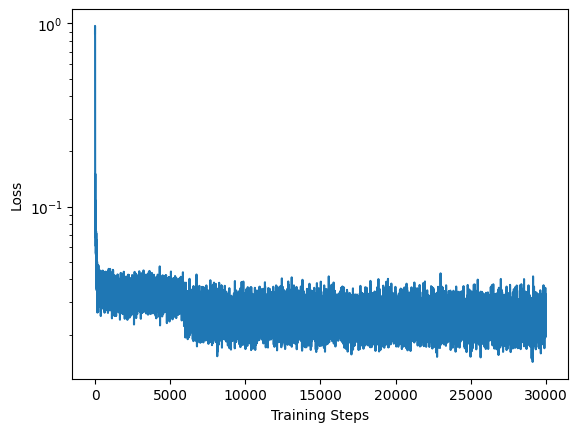

In [11]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [72]:
my_net.eval()
val_true_fluxes = None
val_est_fluxes = []
with torch.inference_mode():
    val_catalog = image_simulator.generate(batch_size=val_batch_size, 
                                               seed=seed)
    for i in tqdm.tqdm(list(range(val_iters))):
        target_fluxes = val_catalog["fluxes"][:, 0:1]  # (b, 1)
        if val_true_fluxes is None:
            val_true_fluxes = target_fluxes
        else:
            assert torch.allclose(val_true_fluxes, target_fluxes)
        input_image = val_catalog["images"].permute([0, 3, 1, 2])
        match image_normalize_strategy:
            case "none":
                pass
            case "log":
                input_image = torch.log1p(input_image)
            case "linear_scale":
                input_image = input_image / 1000
            case _:
                raise NotImplementedError()
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (val_batch_size, 1),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, eta=ddim_eta)
        val_est_fluxes.append(decode_flux(sample).cpu())
val_est_fluxes = torch.stack(val_est_fluxes, dim=0)

100%|██████████| 2500/2500 [27:46<00:00,  1.50it/s]


In [73]:
val_true_fluxes = val_true_fluxes.cpu()

In [74]:
val_true_fluxes.shape

torch.Size([10000, 1])

In [75]:
val_est_fluxes.shape

torch.Size([2500, 10000, 1])

In [76]:
torch.mean((val_true_fluxes - val_est_fluxes) ** 2)

tensor(98703.5000)

In [77]:
torch.mean(torch.abs(val_true_fluxes - val_est_fluxes))

tensor(192.6189)

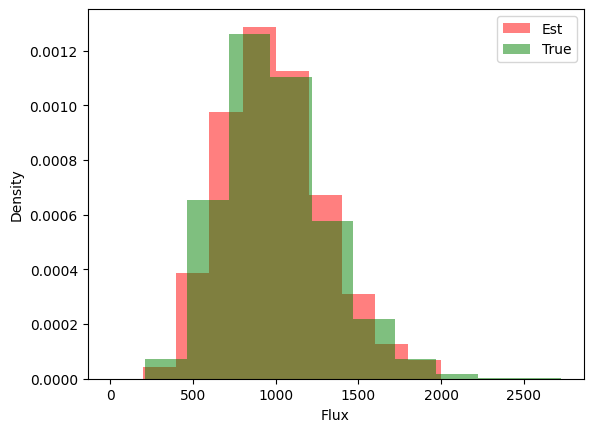

In [78]:
plt.hist(val_est_fluxes.flatten(), color="red", alpha=0.5, density=True, label="Est")
plt.hist(val_true_fluxes.flatten(), color="green", alpha=0.5, density=True, label="True")
plt.ylabel("Density")
plt.xlabel("Flux")
plt.legend()
plt.show()

In [79]:
ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
left_q_points = [(1.0 - c) / 2 for c in ci_cover]
right_q_points = [1.0 - lq for lq in left_q_points]
actual_ci_cover = []
for q in zip(left_q_points, right_q_points):
    q = torch.tensor(q)
    est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)
    above_lower_bound = val_true_fluxes[:, 0] > est_fluxes_q[:, 0, 0]
    below_upper_bound = val_true_fluxes[:, 0] < est_fluxes_q[:, 0, 1]
    actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / val_true_fluxes.shape[0])

In [80]:
actual_ci_cover = torch.cat([a.unsqueeze(0) for a in actual_ci_cover])

In [81]:
actual_ci_cover

tensor([0.0308, 0.0831, 0.1418, 0.1986, 0.2489, 0.2944, 0.3417, 0.3914, 0.4409,
        0.4889, 0.5356, 0.5806, 0.6236, 0.6665, 0.7095, 0.7515, 0.7952, 0.8438,
        0.9049])

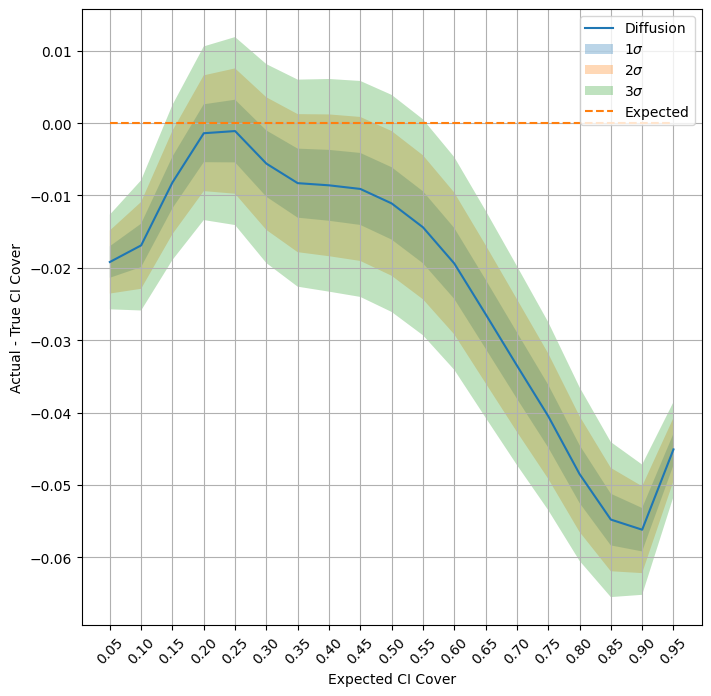

In [82]:
plt.figure(figsize=(8, 8))
a_m_c = actual_ci_cover - ci_cover
ci_sigma = (ci_cover * (1 - ci_cover) / val_batch_size) ** 0.5
plt.plot(ci_cover, a_m_c, label="Diffusion")
plt.fill_between(ci_cover, a_m_c - ci_sigma, a_m_c + ci_sigma, alpha=0.3, label=r"$1\sigma$")
plt.fill_between(ci_cover, a_m_c - 2 * ci_sigma, a_m_c + 2 * ci_sigma, alpha=0.3, label=r"$2\sigma$")
plt.fill_between(ci_cover, a_m_c - 3 * ci_sigma, a_m_c + 3 * ci_sigma, alpha=0.3, label=r"$3\sigma$")
plt.plot(ci_cover, torch.zeros_like(ci_cover), linestyle="dashed", label="Expected")
plt.legend(loc="upper right")
plt.grid()
plt.xticks(ci_cover, rotation=45)
plt.xlabel("Expected CI Cover")
plt.ylabel("Actual - True CI Cover")
plt.show()

In [83]:
val_catalog = move_data_to_device(val_catalog, "cpu")

In [84]:
true_post_dist = image_simulator.post_dist(val_catalog)

In [85]:
(-1 * true_post_dist.log_prob(val_est_fluxes.squeeze(-1))).mean()

tensor(inf)

In [86]:
(-1 * true_post_dist.log_prob(true_post_dist.sample((val_iters, )))).mean()

tensor(5.4496)

In [87]:
def wasserstein_distance(est_samples: torch.Tensor, true_samples: torch.Tensor):
    assert est_samples.ndim == 2  # (val_iters, val_batch_size)
    assert est_samples.shape == true_samples.shape
    sorted_true_samples = torch.sort(true_samples, dim=0, descending=False)[0]
    sorted_est_samples = torch.sort(est_samples, dim=0, descending=False)[0]
    return torch.abs(sorted_est_samples - sorted_true_samples).mean(dim=0)  # (b, )

In [88]:
wasserstein_distance(val_est_fluxes.squeeze(-1), true_post_dist.sample((val_iters, )).cpu()).mean()

tensor(12.2412)

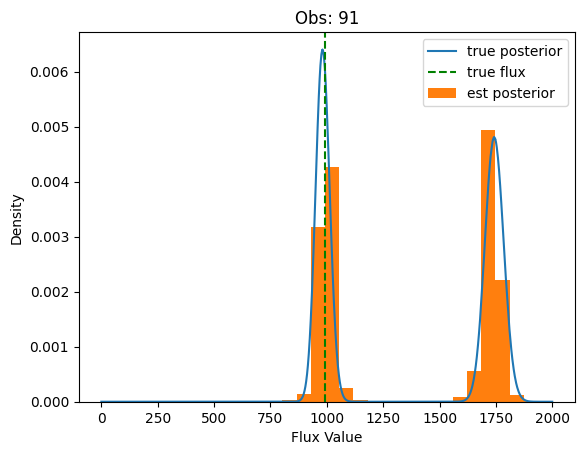

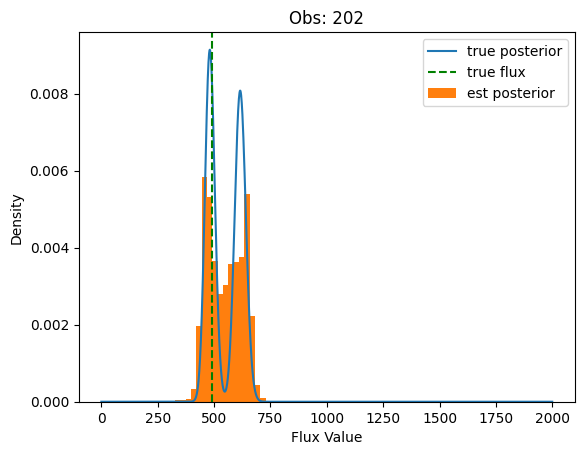

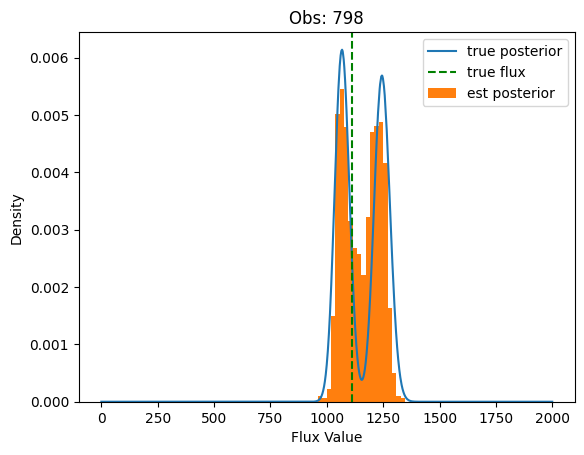

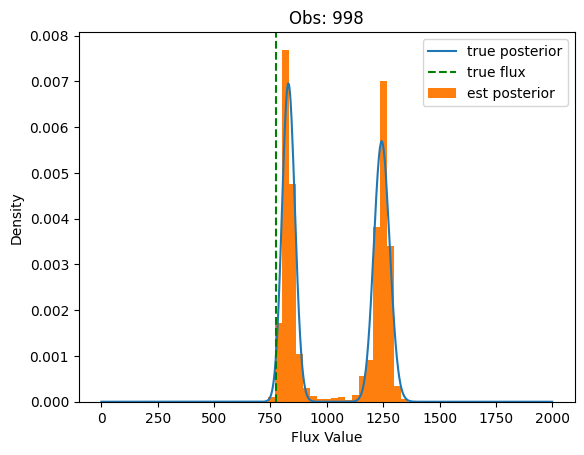

In [89]:
x = torch.linspace(0, 2000, 5000)
obs_index = [91, 202, 798, 998]
for i in obs_index:
    plt.plot(x, true_post_dist.log_prob(x.view(-1, 1))[:, i].exp().cpu(), label="true posterior")
    plt.axvline(x=val_true_fluxes[i].item(), color="green", linestyle="dashed", label="true flux")
    plt.hist(val_est_fluxes[:, i, 0].cpu(), density=True, bins=20, label="est posterior")
    plt.legend()
    plt.xlabel("Flux Value")
    plt.ylabel("Density")
    plt.title(f"Obs: {i}")
    plt.show()